In [1]:
# Nötige Imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaTokenizer
import tensorflow as tf
tf.keras.__version__
import torch
from transformers import pipeline
import glob
from tqdm import tqdm
import pandas as pd
import fileinput

# GPU benutzen
##try:
#    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#    device = "cuda:0" if torch.cuda.is_available() else "cpu"
#    print("Cuda available: ", torch.cuda.is_available())
#    print("Cuda current device: ", torch.cuda.current_device())
#    print("Cuda device s: ", torch.cuda.device(0))
#    print("Cuda device count: ", torch.cuda.device_count())
#    print("Cuda device name: ", torch.cuda.get_device_name(0))
#    gpus = tf.config.experimental.list_physical_devices('GPU')
#    memli=4000
#    if gpus:
#        try:
#            tf.config.experimental.set_virtual_device_configuration(
#            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memli)])
#            print("Memory limit for gpu is", memli,"mb")
#        except RuntimeError as e:
#            print(e)
#except RuntimeError as e:
#    print("no gpu")

In [2]:
tqdm.pandas()

In [3]:
# Modell laden, Tokenizer importieren
tokenizer2 =  RobertaTokenizer.from_pretrained("bhadresh-savani/roberta-base-emotion", do_lower_case=True)

# BERT-Pipeline laden
classifier = pipeline("text-classification",model='bhadresh-savani/roberta-base-emotion', return_all_scores=True)


Metal device set to: Apple M1


2022-08-31 16:24:46.770978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-31 16:24:46.771113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


In [4]:
# Funktion zur Ermittlung des Durchschnitts der Scores
def calc_scores (temp_list_pred,le):
    if le == 0:
        le = 1
    score_sadness = 0
    score_joy = 0
    score_love = 0
    score_anger = 0
    score_fear = 0
    score_surprise = 0

    for x in temp_list_pred:
        score_sadness += x[0]["score"]
        score_joy += x[1]["score"]
        score_love += x[2]["score"]
        score_anger += x[3]["score"]
        score_fear += x[4]["score"]
        score_surprise += x[5]["score"]
        
    if score_sadness != 0:
        score_sadness = score_sadness/le
    if score_joy != 0:
        score_joy = score_joy/le
    if score_joy != 0:
        score_love = score_love/le
    if score_anger!= 0:
        score_anger = score_anger/le 
    if score_fear != 0:
        score_fear = score_fear/le
    if score_surprise != 0:
        score_surprise = score_surprise/le
    list_all = [score_sadness,score_joy,score_love,score_anger,score_fear,score_surprise]
    #print(list_all)
    return(list_all)

def title_scores (temp_list_pred_titel,le):
    if le == 0:
        le = 1
    score_sadness = 0
    score_joy = 0
    score_love = 0
    score_anger = 0
    score_fear = 0
    score_surprise = 0

    for x in temp_list_pred_titel:
        score_sadness += x[0]["score"]
        score_joy += x[1]["score"]
        score_love += x[2]["score"]
        score_anger += x[3]["score"]
        score_fear += x[4]["score"]
        score_surprise += x[5]["score"]
        
    if score_sadness != 0:
        score_sadness = score_sadness/le
    if score_joy != 0:
        score_joy = score_joy/le
    if score_joy != 0:
        score_love = score_love/le
    if score_anger!= 0:
        score_anger = score_anger/le 
    if score_fear != 0:
        score_fear = score_fear/le
    if score_surprise != 0:
        score_surprise = score_surprise/le
    
    list_all2 = [score_sadness,score_joy,score_love,score_anger,score_fear,score_surprise]
    return(list_all2)

### Modell anwenden

In [13]:
# Variablen erstellen
threshold = 400
df_length= 1734

temp_list_pred=[]
temp_list_pred_titel=[]
list_pred = []
list_pred_titel = []
out = []
out2=[]
# Loop durch in Daten-Pipeline erstellte Exports
for files in glob.glob("for_stance16.csv"):
    #print("reading from: "+ files)
    # DF einlesen
    df = pd.read_csv(files)
    
    # DF kürzen für Prototyp
    df = df[:df_length]
    
    # Loop durch DF
    for lines in tqdm(df.content):
        temp_list_pred=[]
        for chunk in lines.split('. '):
            if out and len(chunk)+len(out[-1]) < threshold:
                out[-1] += ' '+chunk+'.'
            else:
                out.append(chunk+'.') 


            prediction = classifier(chunk,)
            temp_list_pred.append(prediction)

         
        res = calc_scores(temp_list_pred,len(chunk))
        list_pred.append(res)
        
    

    for lines in tqdm(df.Titel):
        temp_list_pred_titel= []
        prediction2 = classifier(lines,)
        temp_list_pred_titel.append(prediction2) 
        res2 = title_scores(temp_list_pred_titel,len(chunk))
        list_pred_titel.append(res2)

    
    # Predictions an DF anhängen
    df["scores_text"] = list_pred
    df["scores_titel"] = list_pred_titel
    #print(list_pred_titel)
values=[]
for line in tqdm(df.scores_text):
    temp_pos = line[1] + line[2] + line[5]
    temp_neg = -abs(line[0] + line[3] + line[4])
    values.append(temp_pos + temp_neg)
df["scores_text_sum"] = values

values2=[]
for line in tqdm(df.scores_titel):   
    temp_pos2 = line[1] + line[2] + line[5]
    temp_neg2 = -abs(line[0] + line[3] + line[4])
    values2.append(temp_pos2 + temp_neg2)
df["scores_titel_sum"] = values2
df=df.drop(['scores_text', 'scores_titel'], axis=1)
df.to_csv("final_df1.csv")
#print("rdy")    
df

100%|██████████████████████████████████| 1734/1734 [00:00<00:00, 2395560.98it/s]


,Unnamed: 0.1,Unnamed: 0,Kategorie,Titel,Autor,Datum,content,scores_text_sum,scores_titel_sum
0,0,14359,Opinions,“Shotgun Justice: One Prosecutor’s Crusade Aga...,Robert B. Mitchell,2012-12-15T00:10:12Z,By Michael Lee PopeHistory Press. 126 pp. Pape...,-0.027489,-0.002797
1,1,14366,Politics,A normally stoic president sheds tears over ma...,Philip Rucker; Scott Wilson,2012-12-15T01:30:00Z,"President Obama, so often cool and unemotional...",-0.130385,-0.002634
2,2,14378,Local,Sandy Hook shooting: How can we protect our ki...,Petula Dvorak,2012-12-15T05:24:53Z,"We live in a society that makes it very, very ...",-0.084744,-0.001800
3,3,14380,Local,Conn. school shooting prompts gun-control serm...,Nikita Stewart,2012-12-15T17:19:42Z,"The Rev. Gary Hall, dean of Washington Nationa...",-0.007602,-0.002526
4,4,14382,Local,"In Pr. George’s County, more than 150 guns col...",Ovetta Wiggins,2012-12-15T20:28:28Z,The gun buyback event in Prince George’s Count...,-0.029431,-0.002758
...,...,...,...,...,...,...,...,...,...
1729,1729,121391,Fancy Stats,The Hawks’ shooting in their Game 1 loss to Wi...,Neil Greenberg,2015-05-04T14:35:18Z,The Washington Wizards once again won a playof...,0.004537,-0.002716
1730,1730,121417,The Watch,When violence and lawlessness are acceptable,Radley Balko,2015-05-04T17:42:15Z,"Yesterday, the Fox News show Fox & Friends dev...",-0.409940,-0.002737
1731,1731,121553,Local,Fairfax County police release video in 2009 of...,Tom Jackman,2015-05-06T21:33:21Z,Note: This post has been updated to edit the v...,-0.104839,-0.002810
1732,1732,121734,Post Nation,Oregon expands background checks to almost all...,Mark Berman,2015-05-11T21:46:44Z,Oregon Gov. Kate Brown signed a bill Monday ex...,-0.016458,-0.002630


0	sadness <br>
1 	joy <br>
2	love <br>
3	anger <br>
4	fear <br>
5	suprise <br>


Topic_Modeling

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_sm
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
df=pd.read_csv("final_df.csv")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
# Our spaCy model:
nlp = en_core_web_sm.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df['Titel']):
    proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_p

In [7]:
df['tokens'] = tokens
df['tokens']

0       [shotgun, justice, prosecutor, crusade, crime,...
1       [stoic, president, shed, tear, mass, shooting,...
2       [sandy, hook, shooting, protect, kid, culture,...
3       [school, shooting, prompt, gun, control, sermo...
4       [pr, george, county, gun, collect, gun, buybac...
                              ...                        
1729    [hawks, shooting, game, loss, wizards, bad, th...
1730                  [violence, lawlessness, acceptable]
1731    [fairfax, county, police, release, video, offi...
1732    [oregon, expand, background, check, gun, sale,...
1733    [police, swat, team, single, traffic, cop, kil...
Name: tokens, Length: 1734, dtype: object

In [8]:
dictionary = Dictionary(df['tokens'])
print(dictionary.token2id)


{'alexandria': 0, 'arlington': 1, 'corruptionin': 2, 'crime': 3, 'crusade': 4, 'justice': 5, 'lee': 6, 'michael': 7, 'pope': 8, 'prosecutor': 9, 'shotgun': 10, 'child': 11, 'mass': 12, 'president': 13, 'shed': 14, 'shooting': 15, 'stoic': 16, 'tear': 17, 'accept': 18, 'culture': 19, 'gun': 20, 'hook': 21, 'kid': 22, 'protect': 23, 'sandy': 24, 'cathedral': 25, 'control': 26, 'national': 27, 'prompt': 28, 'school': 29, 'sermon': 30, 'buyback': 31, 'collect': 32, 'county': 33, 'event': 34, 'george': 35, 'pr': 36, 'annual': 37, 'guadalupe': 38, 'include': 39, 'nw': 40, 'remembrance': 41, 'victim': 42, 'devastating': 43, 'inflict': 44, 'wound': 45, 'newtown': 46, 'recovery': 47, 'shoot': 48, 'step': 49, 'take': 50, 'home': 51, 'let': 52, 'loath': 53, 'mother': 54, 'people': 55, 'shooter': 56, 'delay': 57, 'department': 58, 'election': 59, 'law': 60, 'suggestion': 61, 'tough': 62, 'debate': 63, 'killing': 64, 'point': 65, 'tipping': 66, 'common': 67, 'local': 68, 'refrain': 69, 'violence': 

In [9]:

dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 1, passes=10)

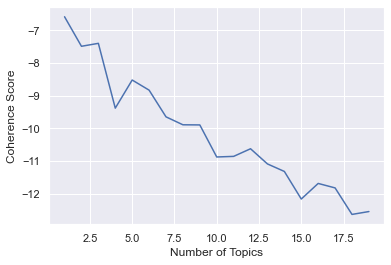

In [10]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

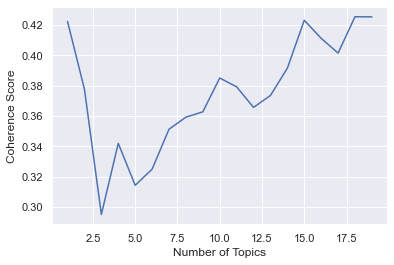

In [11]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [12]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(lda_display, 'lda.html')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: Deprec